# Reflection Agents
Inspiration: https://blog.langchain.dev/reflection-agents/

Reflection Agents consists of two basic components:

1. A **generator**, which is really any agent able to accomplish a task, with or without tools.
2. A **reflector**, which offers criticism and feedback to the generator to have it re-try with advice.

In [7]:
import os

os.environ["OPENAI_API_KEY"] = 'sk-***'

## A simple Agent - Writing Linkedin Posts

In [5]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You write engaging Linkedin Posts."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

llm = ChatOpenAI(model="gpt-4o-mini")

generate = prompt | llm

In [19]:
request = "Write one about me completing day one of filming my AI agent course"
first_draft_response = generate.invoke({"messages": [("user", request)]})

In [20]:
print(first_draft_response.content)

🎬✨ Exciting News! ✨🎬

Today marked Day One of filming my AI Agent Course, and I couldn't be more thrilled! 🚀 The journey to share my passion for AI and its transformative potential has officially begun.

From scripting to shooting, every moment was filled with creativity, challenges, and a lot of learning. I can't wait to dive deeper into the fascinating world of AI agents and help others harness this technology to innovate and solve real-world problems.

A huge thank you to everyone who has supported me on this journey so far! Your encouragement means the world. 🙏

Stay tuned for updates and sneak peeks as we continue this adventure together. Here’s to the exciting road ahead! 🎉💻 #AIAgentCourse #FilmingDay1 #AI #LearningJourney #Innovation #StayTuned


## Reflecting on our agent's work

In [64]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a marketing strategist looking over social media posts. Generate critique and recommendations for the user's post."
            " Provide detailed recommendations on things including length, style, etc.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
reflect = reflection_prompt | llm

In [65]:
reflection = reflect.invoke({"messages": [("user", request), ("user", first_draft_response.content)]})

In [66]:
print(reflection.content)

**Critique of Your Post:**

1. **Length:** The post is relatively well-sized for social media. It captures excitement without being overly verbose. However, it might benefit from slight condensing to sharpen the focus, especially in the opening lines.

2. **Style and Tone:** The tone is enthusiastic and personal, which is great for engaging your audience. The use of emojis adds a fun, modern touch. However, consider using fewer emojis to maintain a professional tone, especially if your target audience includes industry professionals.

3. **Clarity and Structure:** The post flows well but could be improved with clearer sections. Breaking it into smaller paragraphs or using bullet points for key takeaways might enhance readability.

4. **Call to Action:** While you mention staying tuned, it could be more explicit. Encourage your audience to engage with you, whether it's by asking questions, sharing their thoughts on AI, or following your journey more closely.

5. **Hashtags:** The hashta

## Turning this loop into a graph

In [104]:
from typing import Annotated, List, Sequence
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

In [105]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
def generation_node(state: State) -> State:
    return {"messages": [generate.invoke(state["messages"])]}


def reflection_node(state: State) -> State:
    # Other messages we need to adjust
    # First message is the original user request. We hold it the same for all nodes and use the most recent iteration
    translated = [state["messages"][0], HumanMessage(content=state["messages"][-1].content)]
    res = reflect.invoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}


builder = StateGraph(State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_edge(START, "generate")


In [106]:
def should_continue(state: State):
    if len(state["messages"]) >= 6:
        # End after 2 reflections
        return END
    return "reflect"


builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")
graph = builder.compile()

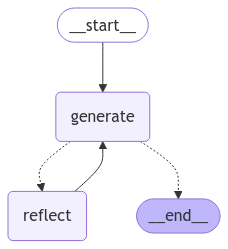

In [96]:
# Compile the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [126]:
drafts = []
for event in graph.stream({"messages": [("user", request)]}):
    for node_name, output in event.items():
        print(f'At Node: {node_name}. Output: {output["messages"][-1].content}')
        if node_name == 'generate':
            drafts.append(output["messages"][-1])
        print('----')

At Node: generate. Output: 🎬 Exciting Milestone Alert! 🚀

Today marked Day One of filming my AI Agent course, and I couldn't be more thrilled! 🎉✨

After months of planning, brainstorming, and structuring the content, it's incredible to see it all come to life. I’ve poured my passion for artificial intelligence into this course, and I’m eager to share insights that can empower others to harness the potential of AI agents in their own projects.

Filming was a blend of exhilarating and nerve-wracking moments, but each take brought me closer to my vision. I can't wait to see how this journey unfolds and to share it with all of you!

A special shoutout to my amazing crew for their support and expertise! 🙌 

Stay tuned for more updates as we continue this adventure. Let’s embrace the future of AI together! 💡🤖

#AI #Filming #CourseCreation #LearningJourney #Innovation #ArtificialIntelligence
----
At Node: reflect. Output: **Critique of the Post:**

Overall, your post has a positive energy and

In [127]:
for i, draft in enumerate(drafts):
    print(f'Draft {i}')
    print('-----------------------------------------------------------')
    print(draft.content)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

Draft 0
-----------------------------------------------------------
🎬 Exciting Milestone Alert! 🚀

Today marked Day One of filming my AI Agent course, and I couldn't be more thrilled! 🎉✨

After months of planning, brainstorming, and structuring the content, it's incredible to see it all come to life. I’ve poured my passion for artificial intelligence into this course, and I’m eager to share insights that can empower others to harness the potential of AI agents in their own projects.

Filming was a blend of exhilarating and nerve-wracking moments, but each take brought me closer to my vision. I can't wait to see how this journey unfolds and to share it with all of you!

A special shoutout to my amazing crew for their support and expertise! 🙌 

Stay tuned for more updates as we continue this adventure. Let’s embrace the future of AI together! 💡🤖

#AI #Filming #CourseCreation #LearningJourney #Innovation #ArtificialIntelligence
-----------------------------------------------------------
-

In [118]:
# Listen for state updates
for event in graph.stream({"messages": [("user", request)]}, stream_mode=["messages", "values"]):
    if event[0] == 'values': 
        print(event[1].keys(), len(event[1]['messages']))
        print(event[1]['messages'][-1].content)

dict_keys(['messages']) 1
Write one about me completing day one of filming my AI agent course
dict_keys(['messages']) 2
🚀 Exciting Milestone Alert! 🎬

Today marks Day One of filming my AI Agent course, and I can’t help but feel a mix of exhilaration and gratitude. 🌟

As I step into the world of artificial intelligence, I’m not just sharing knowledge; I’m on a mission to empower others to harness the potential of AI in their lives and careers. From understanding the fundamentals to exploring real-world applications, this course is designed to break down complex concepts and make them accessible to everyone. 🤖✨

A big thank you to my amazing team for their support and creativity. Your enthusiasm fuels this journey! 🙌

Stay tuned for updates as we dive deeper into the fascinating realm of AI. Together, let’s unlock new possibilities and redefine what’s possible! 💡 

#AIAgentCourse #FilmingDay #ArtificialIntelligence #Education #Empowerment #LifelongLearning
dict_keys(['messages']) 3
**Cri